# **Imports**

In [ ]:
import numpy as np
import cv2 
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
from shapely.geometry import Point
from shapely.geometry import Polygon
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames

# **Load Videos**

In [ ]:
book_video = loadVid("/content/drive/MyDrive/Assignment2_CV/book.mov")
ar_video = loadVid("/content/drive/MyDrive/Assignment2_CV/ar_source.mov")

book_img = cv2.imread("/content/drive/MyDrive/Assignment2_CV/cv_cover.jpg",0)

# **Getting Correspondences**

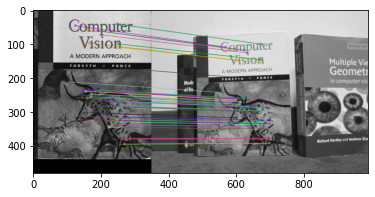

(<matplotlib.image.AxesImage at 0x7f914e739810>, None)

In [ ]:
img1 = book_img
img2 = book_video[0]
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.25*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,keypoints_1,img2,keypoints_2,good[:50],img2,flags=2)

good = good[:50]
plt.imshow(img3),plt.show()

# **Compute the Homography Parameters**

In [ ]:
def Compute_H(random_corr):
  A = []
  for corr in random_corr:
     x1 = corr[0]
     y1 = corr[1]
     x2 = corr[2]
     y2 = corr[3]
     a1 = [-x1,-y1, -1, 0, 0, 0, x1*x2, y1*x2, x2]
     a2 = [0, 0, 0, -x1,-y1, -1, x1*y2, y1*y2, y2]
     A.append(a1)
     A.append(a2)
 
  A = np.matrix(A)

  #SVD
  _, _, V  = np.linalg.svd(A)
  H = np.reshape(V[8], (3,3))
  
  H = np.divide(H,H[2,2])
  return H
  

In [ ]:
def getDistance(correspondence,H):

  xy = np.transpose(np.matrix([correspondence[0],correspondence[1],1]))
  xy_dash_estimated = np.dot(H,xy)
  xy_dash_estimated = np.divide(xy_dash_estimated,xy_dash_estimated[2,0])

  xy_dash = np.transpose(np.matrix([correspondence[2],correspondence[3],1]))
  error = np.linalg.norm(xy_dash_estimated - xy_dash)

  return error 

In [ ]:
def RANSAC(correspondences , threshold):
  max_inliers = []
  final_H = None
  err_threshold = 10
  for i in range(1000):

    first_corr = correspondences[random.randrange(0,len(correspondences))]
    second_corr = correspondences[random.randrange(0,len(correspondences))]
    third_corr = correspondences[random.randrange(0,len(correspondences))]
    forth_corr = correspondences[random.randrange(0,len(correspondences))]
    random_corr = np.array([first_corr,second_corr,third_corr,forth_corr])

    H = Compute_H(random_corr);

    inliers=[]
    for i in range(len(correspondences)):
       error = getDistance(correspondences[i],H)
       if error <= err_threshold:
          inliers.append(correspondences[i])

    if len(inliers) > len(max_inliers):
      max_inliers = inliers
      final_H = H

    if (len(max_inliers)/len(correspondences)) > threshold:
      break;

  if(len(max_inliers)!=0):
    final_H = Compute_H(max_inliers)
  return final_H , max_inliers

In [ ]:
correspondenceList = []
for m in good:
  (x1, y1) = keypoints_1[m[0].queryIdx].pt
  (x2, y2) = keypoints_2[m[0].trainIdx].pt
  correspondenceList.append([x1, y1, x2, y2])

correspondence = np.matrix(correspondenceList)
H , inliers = RANSAC(correspondenceList,0.5)


In [ ]:
print(H)
query_pts = np.float32([keypoints_1[m[0].queryIdx]
                 .pt for m in good]).reshape(-1, 1, 2)
 
# maintaining list of index of descriptors
# in train descriptors
train_pts = np.float32([keypoints_2[m[0].trainIdx]
                 .pt for m in good]).reshape(-1, 1, 2)
 
# finding  perspective transformation
# between two planes
matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 10.0)
print(matrix)

[[ 7.63454251e-01  5.00241167e-03  1.19983903e+02]
 [-5.94279873e-02  7.77320482e-01  7.86387537e+01]
 [-1.18397752e-04 -6.69842837e-05  1.00000000e+00]]
[[ 7.71060387e-01  2.74793728e-03  1.19644737e+02]
 [-5.34364425e-02  7.76953111e-01  7.80731218e+01]
 [-9.66585537e-05 -7.60532183e-05  1.00000000e+00]]


# **Calculate Book Coordinates**

In [ ]:
img2 = book_video[0]
img_ar_video = ar_video[0]

img_ar_video = cv2.resize(img_ar_video, (img2.shape[1],img2.shape[0]))

cornersBook = np.array([[0,0,1],[0,img1.shape[0]-1,1],[img1.shape[1]-1,img1.shape[0]-1,1],[img1.shape[1]-1,0,1]])

center_ar_video =np.add(np.array([0,0]),np.array([img_ar_video.shape[1]-1,img_ar_video.shape[0]-1]))/2

book_corners_video = []
for i in cornersBook:
  xy = np.transpose(np.matrix(i))
  xy_dash_estimated = np.dot(H,xy)
  xy_dash_estimated = np.divide(xy_dash_estimated,xy_dash_estimated[2,0])

  book_corners_video.append([int (round(xy_dash_estimated[0,0])),int (round(xy_dash_estimated[1,0]))])

#center of book in video
center = np.add(np.array(book_corners_video[0]),np.array(book_corners_video[2])) / 2
diff = center_ar_video - center

#cropping frame 
ar_corners = []
for corner in book_corners_video:
  p1 = np.add(np.array(corner),np.array(diff))
  ar_corners.append([int (round(p1[0])),int (round(p1[1]))])

# **Crop AR Video Frames**

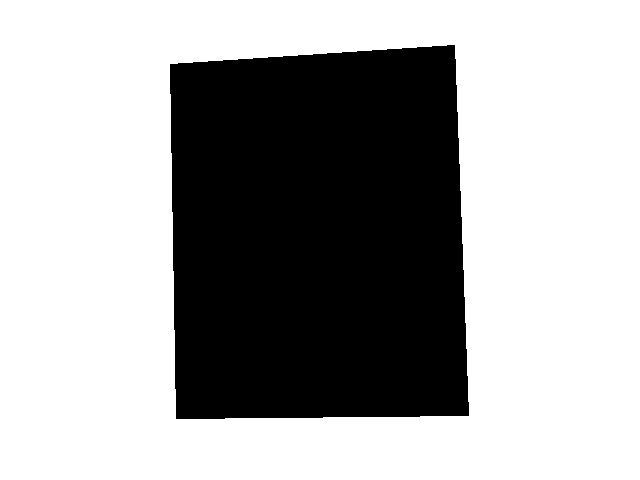

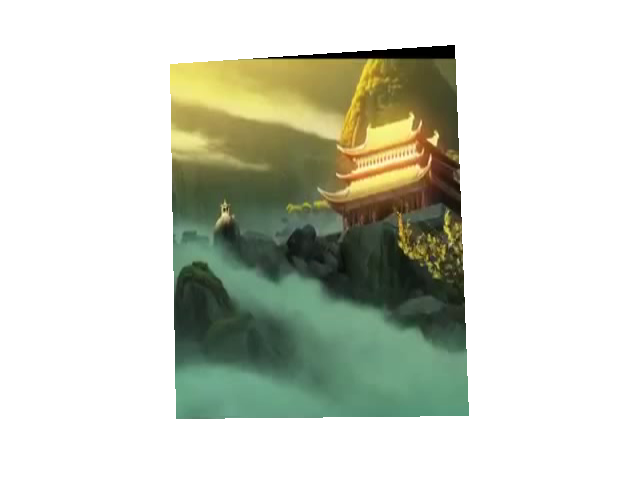

In [ ]:
points = np.array(ar_corners)
copy_of_ar_video = np.zeros_like(img_ar_video)
cv2.fillPoly(copy_of_ar_video, pts=[points], color=(255, 255, 255))
cv2_imshow(cv2.bitwise_not(copy_of_ar_video))
ar_modified = cv2.bitwise_or(img_ar_video,cv2.bitwise_not(copy_of_ar_video))
cv2_imshow(ar_modified)

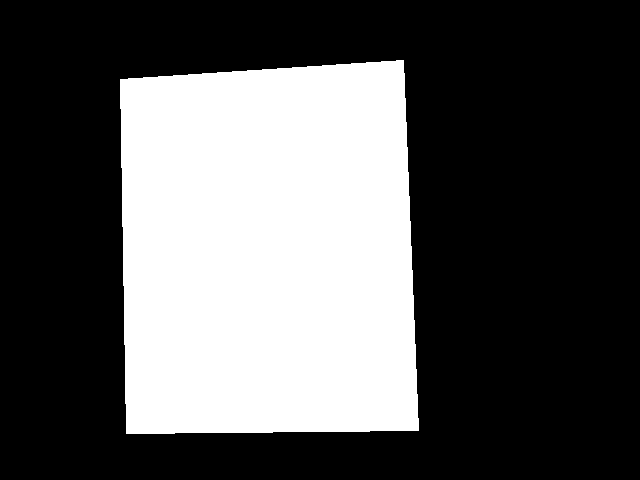

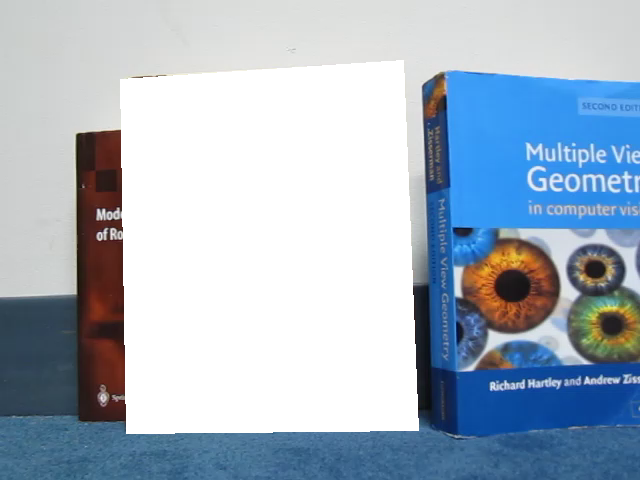

In [ ]:
points = np.array(book_corners_video)
copy_of_book_video = np.zeros_like(img2)
cv2.fillPoly(copy_of_book_video, pts=[points], color=(255, 255, 255))
cv2_imshow(copy_of_book_video)
book_video_modified = cv2.bitwise_or(img2,copy_of_book_video)
cv2_imshow(book_video_modified)

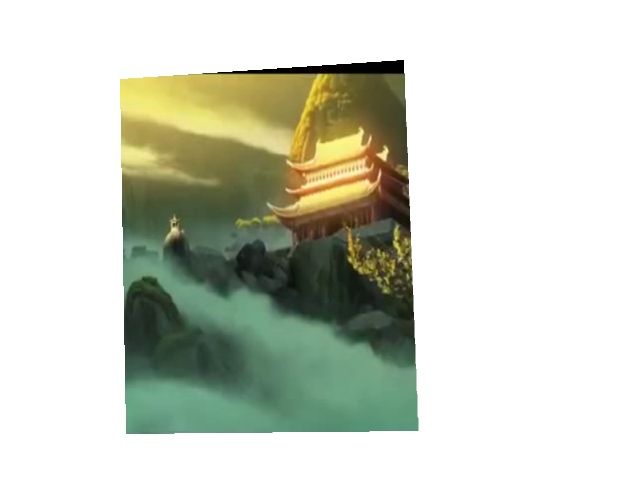

In [ ]:
M = np.float32([
	[1, 0, -diff[0]],
	[0, 1, -diff[1]]
])
shifted = cv2.warpAffine(ar_modified, M, (ar_modified.shape[1], ar_modified.shape[0]))
points = np.array(book_corners_video)
extra = np.zeros_like(img2)
cv2.fillPoly(extra, pts=[points], color=(255, 255, 255))
extra = cv2.bitwise_not(extra)
shifted = cv2.bitwise_or(extra,shifted)
cv2_imshow(shifted)

# **Overlay the First Frame of the Two Videos**

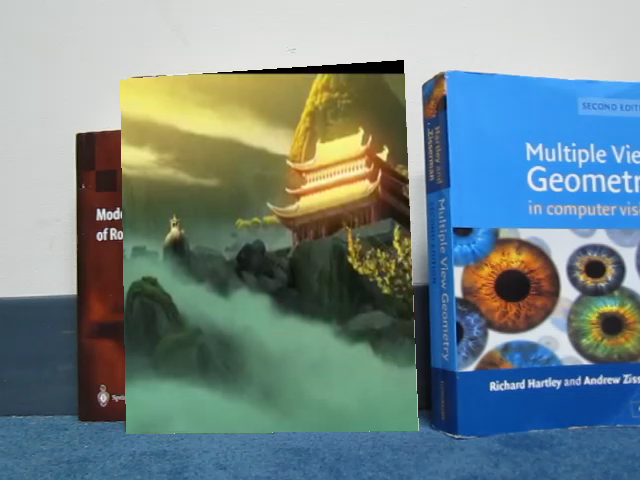

In [ ]:
cv2_imshow(cv2.bitwise_and(book_video_modified,shifted))

# **Creating AR Application**

In [ ]:
img1 = book_img
frames = []
for i in range(len(ar_video)):
  #getting corespondence
  img2 = book_video[i]
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  #sift
  sift = cv2.xfeatures2d.SIFT_create()

  keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

  #feature matching
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.25*n.distance:
          good.append([m])

  # cv2.drawMatchesKnn expects list of lists as matches.
  img3 = cv2.drawMatchesKnn(img1,keypoints_1,img2,keypoints_2,good[:50],img2,flags=2)

  good = good[:50]

  #compute the Homography matrix
  correspondenceList = []
  for m in good:
    (x1, y1) = keypoints_1[m[0].queryIdx].pt
    (x2, y2) = keypoints_2[m[0].trainIdx].pt
    correspondenceList.append([x1, y1, x2, y2])

  correspondence = np.matrix(correspondenceList)
  H , inliers = RANSAC(correspondenceList,0.5)


  #Computing the book corners in book video and croping ar video
  img2 = book_video[i]
  img_ar_video = ar_video[i]

  img_ar_video = cv2.resize(img_ar_video, (img2.shape[1],img2.shape[0]))

  cornersBook = np.array([[0,0,1],[0,img1.shape[0]-1,1],[img1.shape[1]-1,img1.shape[0]-1,1],[img1.shape[1]-1,0,1]])

  center_ar_video =np.add(np.array([0,0]),np.array([img_ar_video.shape[1]-1,img_ar_video.shape[0]-1]))/2

  book_corners_video = []
  for i in cornersBook:
    xy = np.transpose(np.matrix(i))
    xy_dash_estimated = np.dot(H,xy)
    xy_dash_estimated = np.divide(xy_dash_estimated,xy_dash_estimated[2,0])

    book_corners_video.append([int (round(xy_dash_estimated[0,0])),int (round(xy_dash_estimated[1,0]))])

  #center of book in video
  center = np.add(np.array(book_corners_video[0]),np.array(book_corners_video[2])) / 2
  diff = center_ar_video - center

  #cropping frame 
  ar_corners = []
  for corner in book_corners_video:
    p1 = np.add(np.array(corner),np.array(diff))
    ar_corners.append([int (round(p1[0])),int (round(p1[1]))])

  #preparing ar video
  points = np.array(ar_corners)
  copy_of_ar_video = np.zeros_like(img_ar_video)
  cv2.fillPoly(copy_of_ar_video, pts=[points], color=(255, 255, 255))
  #cv2_imshow(cv2.bitwise_not(copy_of_ar_video))
  ar_modified = cv2.bitwise_or(img_ar_video,cv2.bitwise_not(copy_of_ar_video))
  #cv2_imshow(ar_modified)

  #preparing book video
  points = np.array(book_corners_video)
  copy_of_book_video = np.zeros_like(img2)
  cv2.fillPoly(copy_of_book_video, pts=[points], color=(255, 255, 255))
  #cv2_imshow(copy_of_book_video)
  book_video_modified = cv2.bitwise_or(img2,copy_of_book_video)
  #cv2_imshow(book_video_modified)

  #translation of ar video
  M = np.float32([
	[1, 0, -diff[0]],
	[0, 1, -diff[1]]
  ])
  shifted = cv2.warpAffine(ar_modified, M, (ar_modified.shape[1], ar_modified.shape[0]))
  points = np.array(book_corners_video)
  extra = np.zeros_like(img2)
  cv2.fillPoly(extra, pts=[points], color=(255, 255, 255))
  extra = cv2.bitwise_not(extra)
  shifted = cv2.bitwise_or(extra,shifted)
  #cv2_imshow(shifted)

  #final output
  final = cv2.bitwise_and(book_video_modified,shifted)
  cv2_imshow(final)
  frames.append(final)

In [ ]:
video_name = '/content/drive/MyDrive/Assignment2_CV/video.avi'

frame = frames[0]
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, len(frames)/20, (width,height))

for image in frames:
    video.write(image)

cv2.destroyAllWindows()
video.release()